## SPHEREx Concept



In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np 
import pandas as pd

from atm import __version__
print("ATM Version: {}".format(__version__))

ATM Version: 1.1.dev24+g57c30f8


In [2]:
SPHEREX_REPO = "Public-products"
if not os.path.exists(SPHEREX_REPO):
    ! git clone https://github.com/SPHEREx/Public-products

In [3]:
point_source = pd.read_csv(
    os.path.join(SPHEREX_REPO, "FWHM_v28_base_cbe.txt"), 
    index_col=None, 
    delim_whitespace=True,
    skiprows=1,
    names=[
        "lambda [mum]", 
        "FWHM [arsec]"
    ])

In [4]:
point_source["lambda [mum]"].values * 1e-6

array([7.500000e-07, 7.682927e-07, 7.870315e-07, 8.062274e-07,
       8.258915e-07, 8.460352e-07, 8.666702e-07, 8.878085e-07,
       9.094624e-07, 9.316444e-07, 9.543674e-07, 9.776447e-07,
       1.001490e-06, 1.025916e-06, 1.050939e-06, 1.076571e-06,
       1.137073e-06, 1.164807e-06, 1.193217e-06, 1.222319e-06,
       1.252132e-06, 1.282672e-06, 1.313957e-06, 1.346004e-06,
       1.378834e-06, 1.412464e-06, 1.446914e-06, 1.482205e-06,
       1.518356e-06, 1.555389e-06, 1.593325e-06, 1.632187e-06,
       1.680000e-06, 1.720976e-06, 1.762951e-06, 1.805949e-06,
       1.849997e-06, 1.895119e-06, 1.941341e-06, 1.988691e-06,
       2.037196e-06, 2.086883e-06, 2.137783e-06, 2.189924e-06,
       2.243337e-06, 2.298052e-06, 2.354102e-06, 2.411520e-06,
       2.489143e-06, 2.560261e-06, 2.633412e-06, 2.708652e-06,
       2.786042e-06, 2.865643e-06, 2.947519e-06, 3.031733e-06,
       3.118354e-06, 3.207450e-06, 3.299092e-06, 3.393351e-06,
       3.490304e-06, 3.590027e-06, 3.692600e-06, 3.7981

In [5]:
import sys
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from atm.models import STM, FRM, NEATM
from atm.obs import SPHEREx
from atm import fit
from atm import modifyErrors

# Additonal imports to make simulated data
from atm import Config
from atm.functions import calcTss, calcQ
from atm.functions import interpFluxLambdaObsWithSunlight
from atm.functions import calcFluxLambdaObsWithSunlight
from atm.functions import calcFluxLambdaAtObsWithSunlight
from atm.functions import calcFluxLambdaSED
from atm.plotting import plotObservations, plotSED

%matplotlib inline

In [6]:
DPI = 300
SAVE_DIR = "/spherex/"
FORMAT = "png"

SAVE_FIGS = False

In [7]:
m_to_mum = 1e6 # simple conversion from m to micron
km_to_m = 1e3 # conversion km to m

In [8]:
# Instantiate observatory and NEATM class for simulating data
obs = SPHEREx()
model = NEATM(verbose=False)

In [9]:
# Load SPHEREx quadrature lookup tables into memory 
model.loadLambdaTables(obs.filterQuadratureLambdas, verbose=False)

In [10]:
files = glob.glob("*SPHERExSED.dat")

data_dfs = []
for i, file in enumerate(sorted(files)):
    wavelength, mag, magErr, epsilon, albedo = np.loadtxt(file)

    f_split = file.split("_")
    
    r = float(f_split[3][1:])
    d = float(f_split[4][1:])
    t1 = float(f_split[2][1:])
    eps = float(f_split[1][1:])
    
    data = {
        "designation" : ["_".join(f_split[1:5])],
        "obs_id" : [i + 1],
        "r" : [r],
        "delta" : [r - 1],
        "alpha" : [0],
        "logD" : np.log10([d * 1000]),
        "logT1" : np.log10([t1]),
        "eps" : [eps],
        "G" : [0.15],
    }
    flambda = obs.convertMagToFluxLambda(mag)
    flambdaerr = obs.convertMagErrToFluxLambdaErr(mag, magErr)
    for i, (mag_i, magErr_i) in enumerate(zip(mag, magErr)):
        filter_i = obs.filterNames[i]
        data["flux_{}_si".format(filter_i)] = flambda[i]
        data["fluxErr_{}_si".format(filter_i)] = flambdaerr[i]
        data["mag_{}_AB".format(filter_i)] = np.array([mag_i])
        data["magErr_{}_AB".format(filter_i)] = np.array([magErr_i])

    data_dfs.append(pd.DataFrame(data))
    
data = pd.concat(data_dfs)
data.reset_index(
    inplace=True, 
    drop=True
)
columnMapping = {
    "designation" : "designation",
    "obs_id" : "obs_id",
    "r_au" : "r",
    "delta_au" : "delta",
    "alpha_rad" : "alpha",
    "G" : "G",
    "logT1" : "logT1",
    "logD": "logD",
    "eps" : "eps", 
    "flux_si": ["flux_{}_si".format(i) for i in obs.filterNames],
    "fluxErr_si": ["fluxErr_{}_si".format(i) for i in obs.filterNames],
    "mag" : ["mag_{}_AB".format(i) for i in obs.filterNames],
    "magErr" : ["magErr_{}_AB".format(i) for i in obs.filterNames],
}

In [11]:
data

,designation,obs_id,r,delta,alpha,logD,logT1,eps,G,flux_s01_si,...,mag_s94_AB,magErr_s94_AB,flux_s95_si,fluxErr_s95_si,mag_s95_AB,magErr_s95_AB,flux_s96_si,fluxErr_s96_si,mag_s96_AB,magErr_s96_AB
0,E0.94_T400_r2.5_D10.0,1,2.5,1.5,0,4.000000,2.60206,0.94,0.15,1.549997e-08,...,15.485747,0.055535,2.999305e-10,1.527244e-11,15.422859,0.055286,3.295048e-10,1.670512e-11,15.304116,0.055044
1,E0.94_T400_r2.5_D3.0,2,2.5,1.5,0,3.477121,2.60206,0.94,0.15,1.385621e-09,...,18.036602,0.249452,2.888926e-11,6.471105e-12,17.963569,0.243202,3.789999e-11,8.274012e-12,17.652173,0.237029
2,E0.98_T400_r3.0_D17.0,3,3.0,2.0,0,4.230449,2.60206,0.98,0.15,6.634672e-09,...,16.383793,0.067742,1.415339e-10,8.689866e-12,16.238259,0.066662,1.564986e-10,9.460807e-12,16.112495,0.065636
3,E0.98_T400_r3.0_D5.0,4,3.0,2.0,0,3.698970,2.60206,0.98,0.15,5.452311e-10,...,18.569406,0.504898,1.135958e-11,5.088326e-12,18.977005,0.486337,1.477146e-11,6.371958e-12,18.675212,0.468353


Added 0.2 magnitude errors to magErr_s01_AB.
Added 0.2 magnitude errors to magErr_s02_AB.
Added 0.2 magnitude errors to magErr_s03_AB.
Added 0.2 magnitude errors to magErr_s04_AB.
Added 0.2 magnitude errors to magErr_s05_AB.
Added 0.2 magnitude errors to magErr_s06_AB.
Added 0.2 magnitude errors to magErr_s07_AB.
Added 0.2 magnitude errors to magErr_s08_AB.
Added 0.2 magnitude errors to magErr_s09_AB.
Added 0.2 magnitude errors to magErr_s10_AB.
Added 0.2 magnitude errors to magErr_s11_AB.
Added 0.2 magnitude errors to magErr_s12_AB.
Added 0.2 magnitude errors to magErr_s13_AB.
Added 0.2 magnitude errors to magErr_s14_AB.
Added 0.2 magnitude errors to magErr_s15_AB.
Added 0.2 magnitude errors to magErr_s16_AB.
Added 0.2 magnitude errors to magErr_s17_AB.
Added 0.2 magnitude errors to magErr_s18_AB.
Added 0.2 magnitude errors to magErr_s19_AB.
Added 0.2 magnitude errors to magErr_s20_AB.
Added 0.2 magnitude errors to magErr_s21_AB.
Added 0.2 magnitude errors to magErr_s22_AB.
Added 0.2 

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2156.24draws/s]


Found best fit parameters:
 logT1: 2.602 +- 0.001
 logD:  4.001 +- 0.001
Total time: 111.98 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_noSigma/atm_results_run1_noSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 2/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run1_noSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:29<00:00, 2042.65draws/s]


Found best fit parameters:
 logT1: 2.598 +- 0.003
 logD:  3.478 +- 0.002
Total time: 110.81 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_noSigma/atm_results_run1_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 3/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run1_noSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:28<00:00, 2076.24draws/s]


Found best fit parameters:
 logT1: 2.602 +- 0.001
 logD:  4.229 +- 0.001
Total time: 110.58 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_noSigma/atm_results_run1_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 4/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run1_noSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:30<00:00, 1973.77draws/s]


Found best fit parameters:
 logT1: 2.595 +- 0.006
 logD:  3.692 +- 0.004
Total time: 111.26 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_noSigma/atm_results_run1_noSigma.db)...
Done.

Starting fit code: run2_noSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 5/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run2_noSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:40<00:00, 1481.29draws/s]


Found best fit parameters:
 logT1: 2.671 +- 0.006
 logD:  3.648 +- 0.022
 eps:   0.698 +- 0.031
Total time: 123.61 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_noSigma/atm_results_run2_noSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 6/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run2_noSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:43<00:00, 1390.67draws/s]


Found best fit parameters:
 logT1: 2.663 +- 0.009
 logD:  3.135 +- 0.038
 eps:   0.708 +- 0.051
Total time: 125.39 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_noSigma/atm_results_run2_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 7/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run2_noSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:42<00:00, 1417.54draws/s]


Found best fit parameters:
 logT1: 2.706 +- 0.008
 logD:  3.644 +- 0.033
 eps:   0.707 +- 0.044
Total time: 126.22 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_noSigma/atm_results_run2_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 8/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run2_noSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:41<00:00, 1430.10draws/s]


Found best fit parameters:
 logT1: 2.693 +- 0.020
 logD:  3.103 +- 0.081
 eps:   0.700 +- 0.114
Total time: 126.38 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_noSigma/atm_results_run2_noSigma.db)...
Done.

Starting fit code: run3_noSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 9/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run3_noSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's5

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:56<00:00, 1063.06draws/s]


Found best fit parameters:
 logT1:  2.678 +- 0.006
 logD:   3.625 +- 0.022
 eps_S1: 0.660 +- 0.035
 eps_S2: 0.692 +- 0.029
Total time: 149.94 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_noSigma/atm_results_run3_noSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 10/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run3_noSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55'], dt

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:56<00:00, 1059.48draws/s]


Found best fit parameters:
 logT1:  2.669 +- 0.011
 logD:   3.117 +- 0.041
 eps_S1: 0.683 +- 0.059
 eps_S2: 0.706 +- 0.053
Total time: 145.20 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_noSigma/atm_results_run3_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 11/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run3_noSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55'], 

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:55<00:00, 1073.71draws/s]


Found best fit parameters:
 logT1:  2.714 +- 0.007
 logD:   3.612 +- 0.027
 eps_S1: 0.657 +- 0.043
 eps_S2: 0.695 +- 0.035
Total time: 145.45 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_noSigma/atm_results_run3_noSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 12/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run3_noSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55'], dt

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:51<00:00, 1170.35draws/s]


Found best fit parameters:
 logT1:  2.699 +- 0.018
 logD:   3.086 +- 0.069
 eps_S1: 0.674 +- 0.107
 eps_S2: 0.701 +- 0.105
Total time: 139.98 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_noSigma/atm_results_run3_noSigma.db)...
Done.

Starting fit code: run1_withSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 13/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run1_withSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2185.35draws/s]


Found best fit parameters:
 logT1: 2.602 +- 0.003
 logD:  4.001 +- 0.006
Total time: 107.98 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_withSigma/atm_results_run1_withSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 14/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run1_withSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2186.41draws/s]


Found best fit parameters:
 logT1: 2.597 +- 0.006
 logD:  3.477 +- 0.007
Total time: 108.47 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_withSigma/atm_results_run1_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 15/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run1_withSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:25<00:00, 2350.57draws/s]


Found best fit parameters:
 logT1: 2.602 +- 0.003
 logD:  4.229 +- 0.006
Total time: 107.03 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_withSigma/atm_results_run1_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 16/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run1_withSigma
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:29<00:00, 2040.68draws/s]


Found best fit parameters:
 logT1: 2.593 +- 0.010
 logD:  3.686 +- 0.010
Total time: 112.82 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run1_withSigma/atm_results_run1_withSigma.db)...
Done.

Starting fit code: run2_withSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 17/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run2_withSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:40<00:00, 1491.33draws/s]


Found best fit parameters:
 logT1: 2.669 +- 0.020
 logD:  3.653 +- 0.083
 eps:   0.707 +- 0.107
Total time: 124.10 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_withSigma/atm_results_run2_withSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 18/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run2_withSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:41<00:00, 1441.84draws/s]


Found best fit parameters:
 logT1: 2.668 +- 0.027
 logD:  3.109 +- 0.100
 eps:   0.675 +- 0.148
Total time: 125.88 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_withSigma/atm_results_run2_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 19/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run2_withSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:41<00:00, 1436.61draws/s]


Found best fit parameters:
 logT1: 2.696 +- 0.019
 logD:  3.678 +- 0.083
 eps:   0.750 +- 0.095
Total time: 123.95 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_withSigma/atm_results_run2_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 20/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run2_withSigma
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps']
Chains: 30
Samples per Chain: 2000
Burn-in Samples: 500
Effective Samples per Chain: 1500
Threads: 30


Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:39<00:00, 1537.89draws/s]


Found best fit parameters:
 logT1: 2.695 +- 0.041
 logD:  3.056 +- 0.131
 eps:   0.634 +- 0.217
Total time: 120.93 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run2_withSigma/atm_results_run2_withSigma.db)...
Done.

Starting fit code: run3_withSigma

Fitting object E0.94_T400_r2.5_D10.0 (1/4)...
Fit number: 21/24

Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: run3_withSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
 

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:52<00:00, 1136.00draws/s]
/home/moeyensj/software/anaconda3/envs/atm_py38/lib/python3.8/site-packages/corner/corner.py:271: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


Found best fit parameters:
 logT1:  2.681 +- 0.027
 logD:   3.610 +- 0.100
 eps_S1: 0.637 +- 0.163
 eps_S2: 0.678 +- 0.135
Total time: 140.52 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_withSigma/atm_results_run3_withSigma.db)...
Done.

Fitting object E0.94_T400_r2.5_D3.0 (2/4)...
Fit number: 22/24

Fitting E0.94_T400_r2.5_D3.0 with NEATM...
Fit Code: run3_withSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:56<00:00, 1068.17draws/s]


Found best fit parameters:
 logT1:  2.677 +- 0.030
 logD:   3.079 +- 0.110
 eps_S1: 0.625 +- 0.189
 eps_S2: 0.676 +- 0.155
Total time: 146.35 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_withSigma/atm_results_run3_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D17.0 (3/4)...
Fit number: 23/24

Fitting E0.98_T400_r3.0_D17.0 with NEATM...
Fit Code: run3_withSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:58<00:00, 1019.17draws/s]


Found best fit parameters:
 logT1:  2.721 +- 0.018
 logD:   3.582 +- 0.067
 eps_S1: 0.607 +- 0.119
 eps_S2: 0.665 +- 0.101
Total time: 149.04 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_withSigma/atm_results_run3_withSigma.db)...
Done.

Fitting object E0.98_T400_r3.0_D5.0 (4/4)...
Fit number: 24/24

Fitting E0.98_T400_r3.0_D5.0 with NEATM...
Fit Code: run3_withSigma
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:57<00:00, 1049.57draws/s]


Found best fit parameters:
 logT1:  2.707 +- 0.043
 logD:   3.013 +- 0.099
 eps_S1: 0.555 +- 0.202
 eps_S2: 0.591 +- 0.204
Total time: 147.04 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (spherex/run3_withSigma/atm_results_run3_withSigma.db)...
Done.



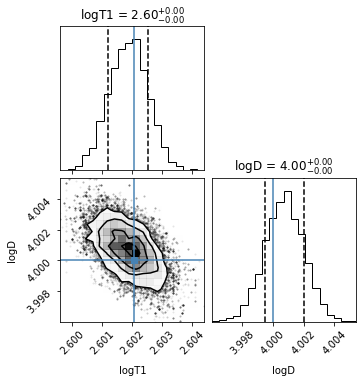

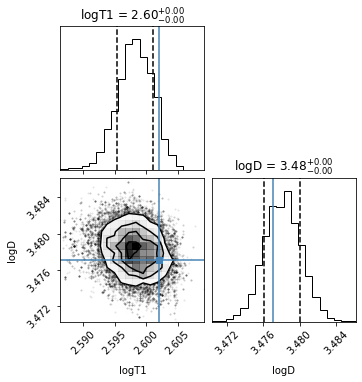

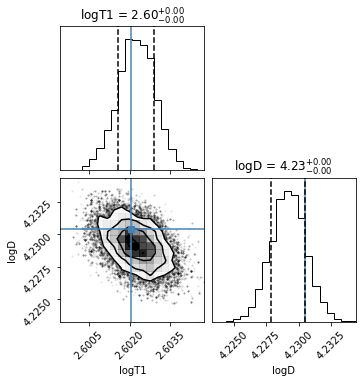

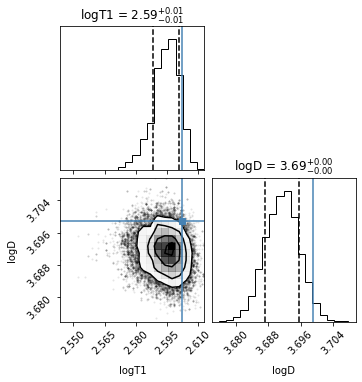

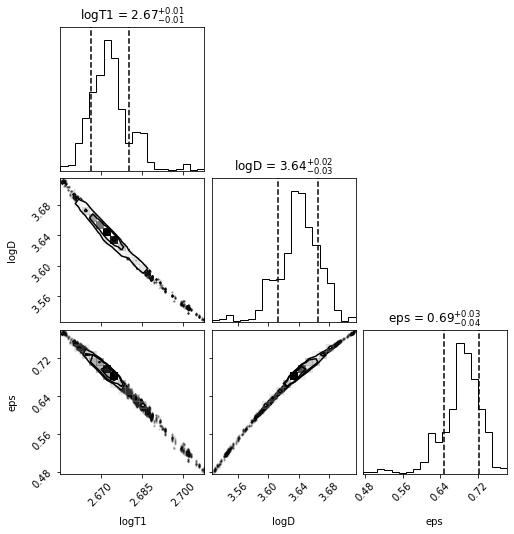

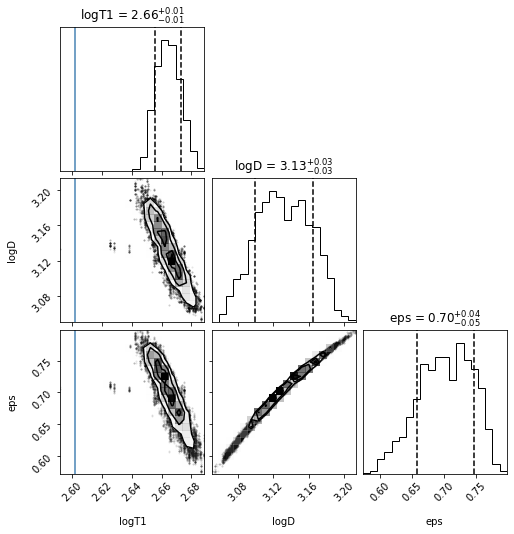

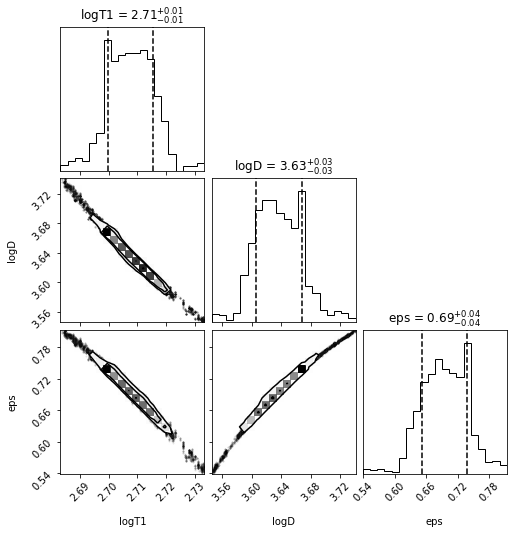

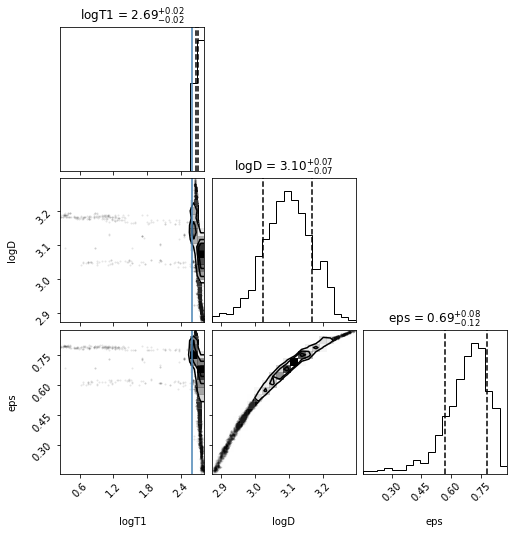

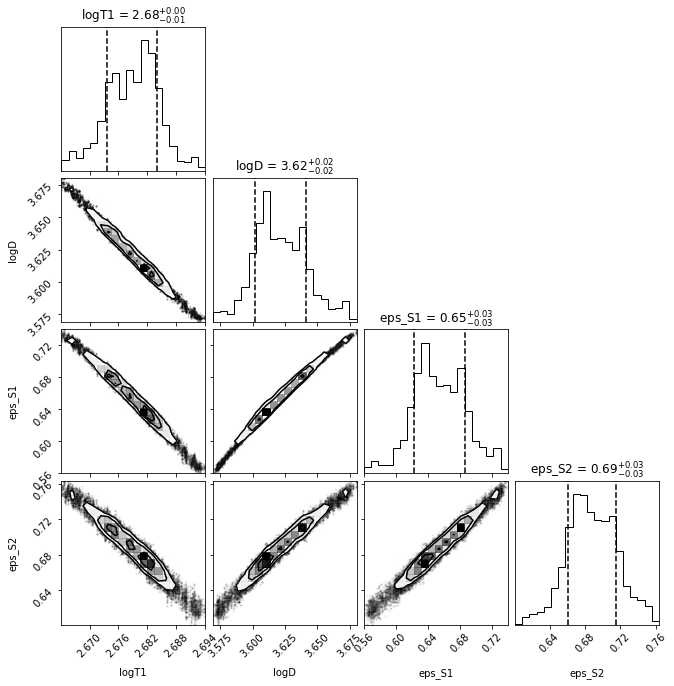

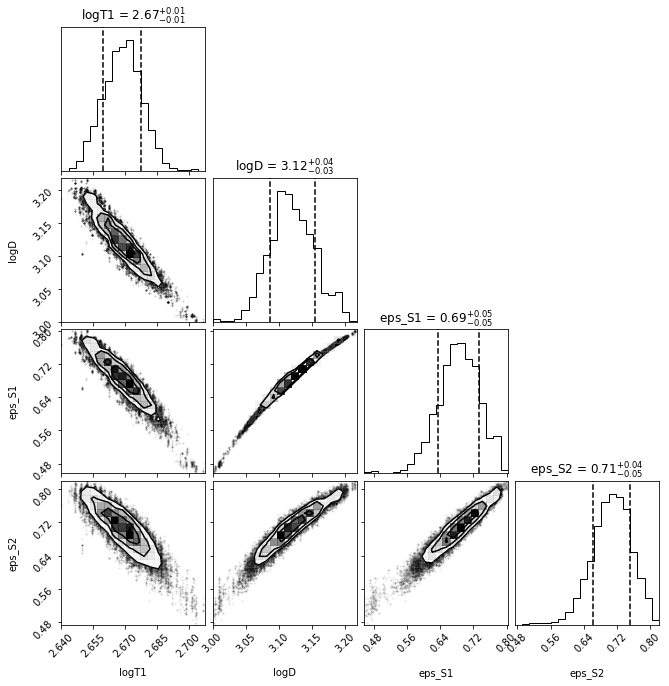

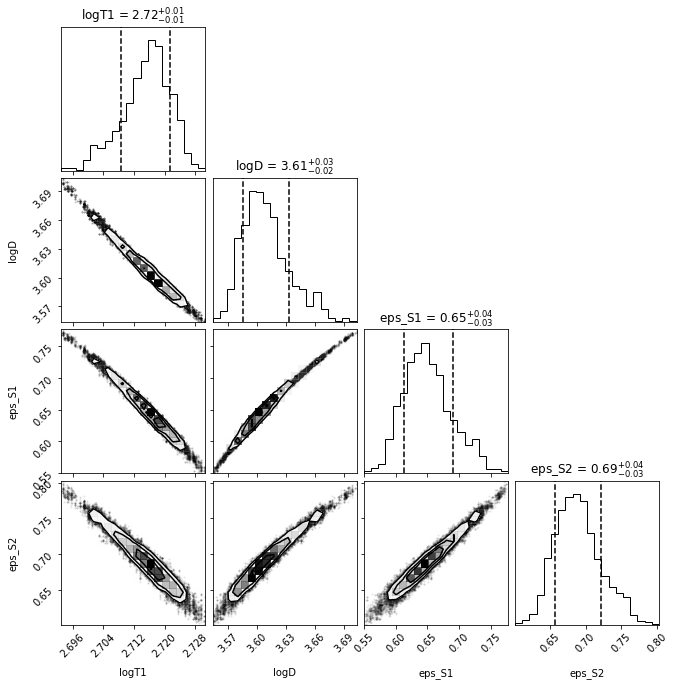

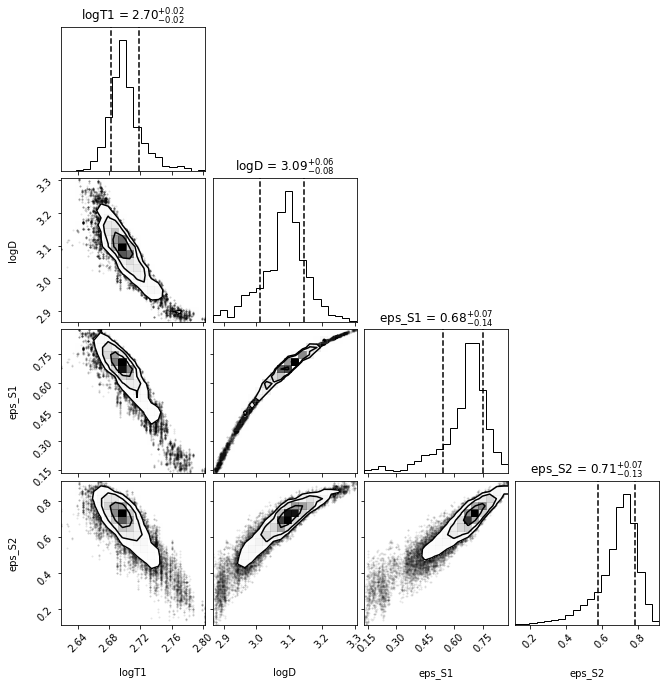

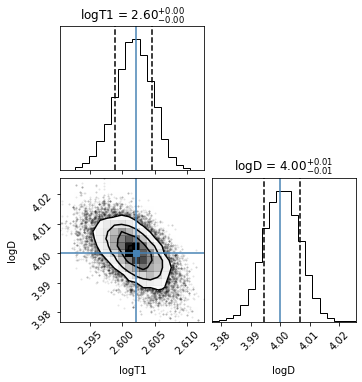

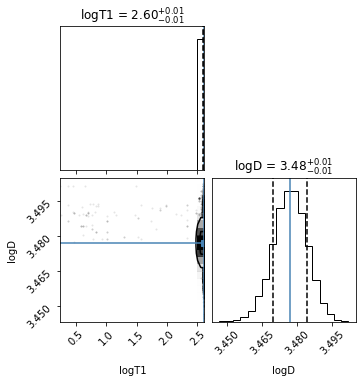

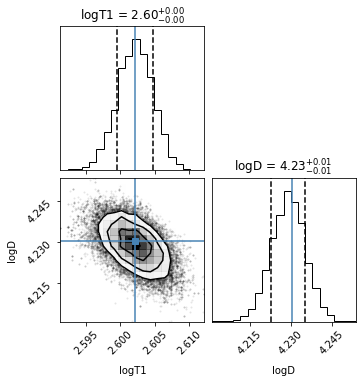

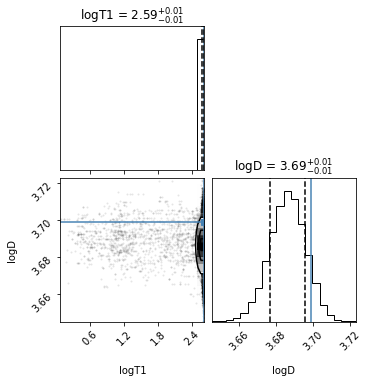

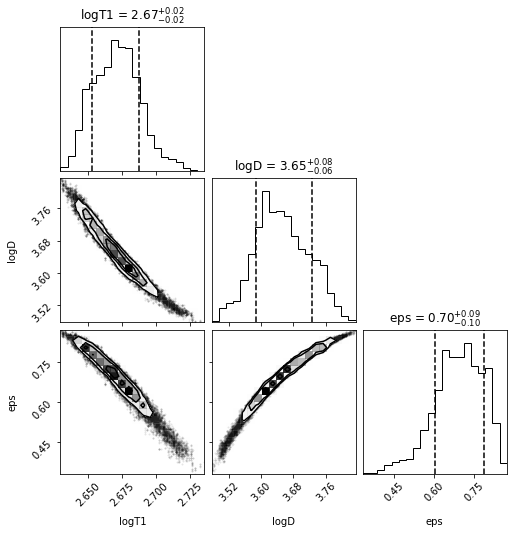

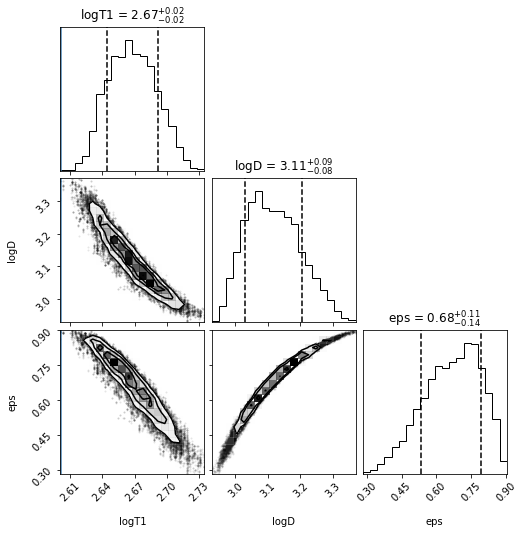

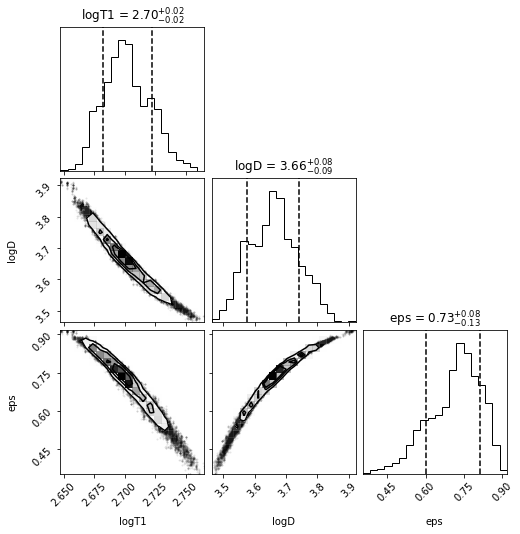

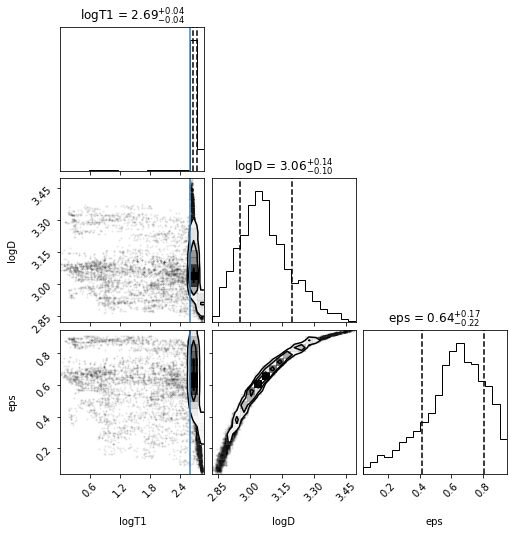

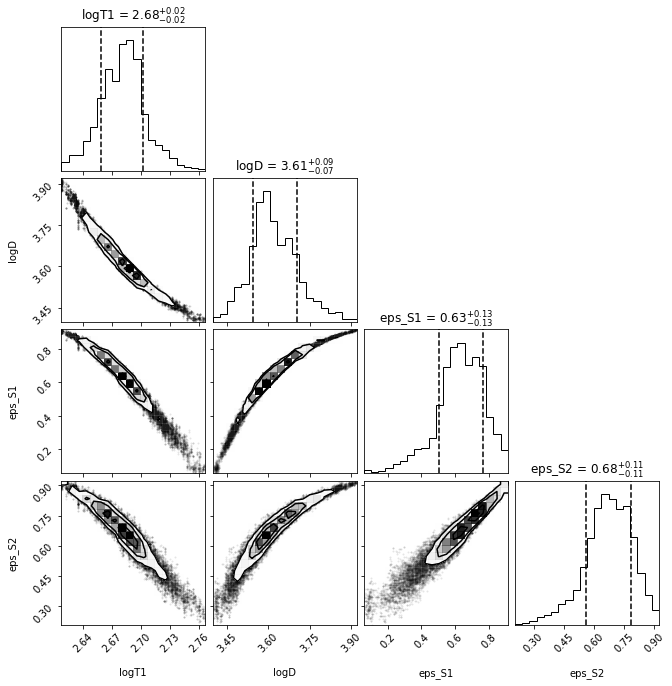

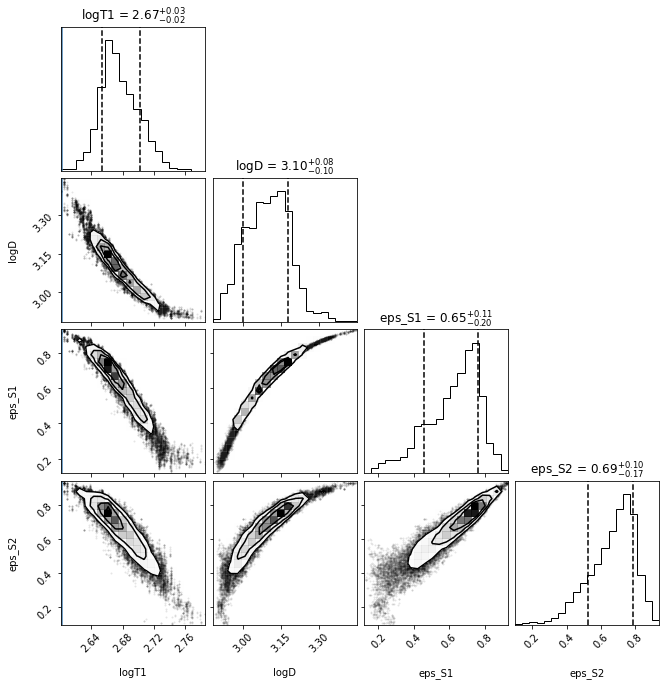

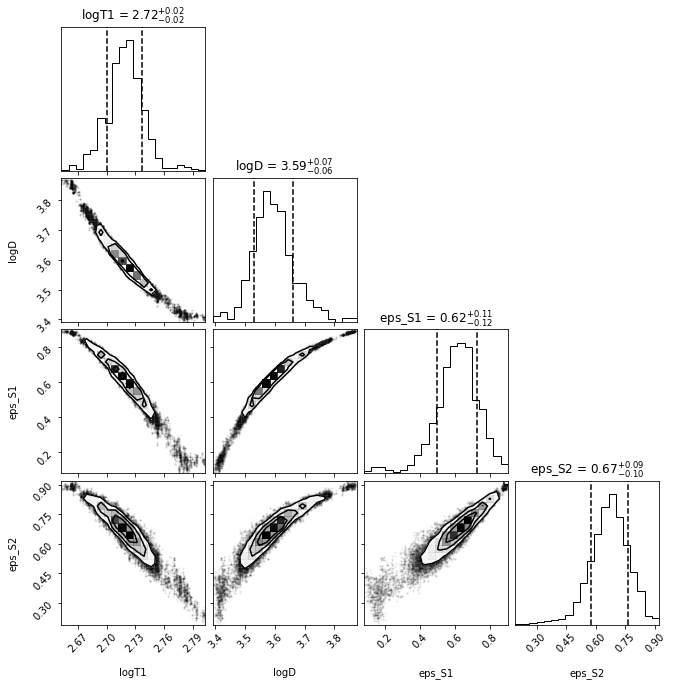

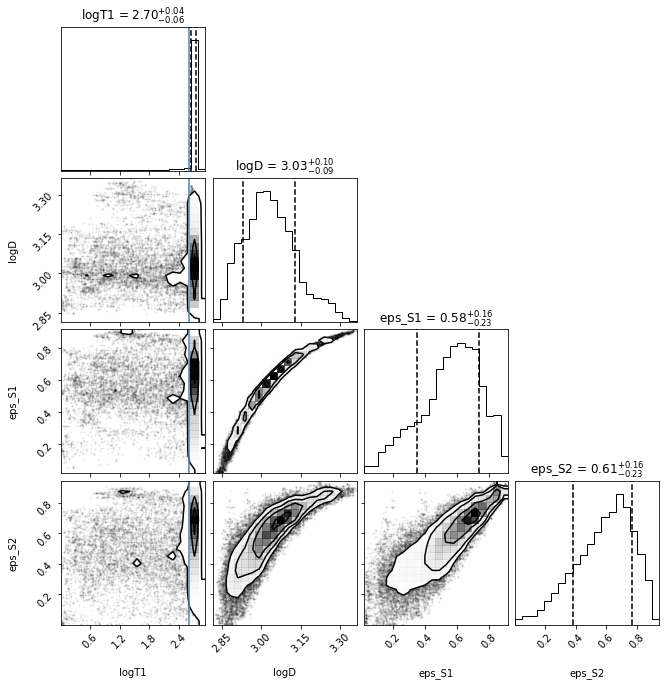

In [12]:
from atm import multiFit

# Initialize data dictionary
dataDict = {}
dataDict["run1_noSigma"] = data.copy()
dataDict["run2_noSigma"] = data.copy()
dataDict["run3_noSigma"] = data.copy()
dataDict["run1_withSigma"] = modifyErrors(data.copy(), obs, sigma=0.2, columnMapping=columnMapping)
dataDict["run2_withSigma"] = modifyErrors(data.copy(), obs, sigma=0.2, columnMapping=columnMapping)
dataDict["run3_withSigma"] = modifyErrors(data.copy(), obs, sigma=0.2, columnMapping=columnMapping)

# Initialize fit dictionary
fitDict = {}
fitDict["run1_noSigma"] = {
    "fitParameters" : ["logT1", "logD"],
    "emissivitySpecification" : None,
    "albedoSpecification": "auto",
    "fitFilters" : "all",
    "columnMapping" : columnMapping
}

fitDict["run2_noSigma"] = {
    "fitParameters" : ["logT1", "logD", "eps"],
    "emissivitySpecification" : None,
    "albedoSpecification": "auto",
    "fitFilters" : "all",
    "columnMapping" : columnMapping
}

lambda_split = 3e-6
fitDict["run3_noSigma"] = {
    "fitParameters" : ["logT1", "logD", "eps_S1", "eps_S2"],
    "emissivitySpecification" : {
        "eps_S1" : np.array(obs.filterNames)[np.where(obs.filterEffectiveLambdas < lambda_split)],
        "eps_S2" : np.array(obs.filterNames)[np.where(obs.filterEffectiveLambdas >= lambda_split)]
    },
    "albedoSpecification": "auto",
    "fitFilters" : "all",
    "columnMapping" : columnMapping
}

fitDict["run1_withSigma"] = fitDict["run1_noSigma"]
fitDict["run2_withSigma"] = fitDict["run2_noSigma"]
fitDict["run3_withSigma"] = fitDict["run3_noSigma"]


# Set fit configuration
fitConfigDict = {
    "chains" : 30,
    "samples" : 1500,
    "burnInSamples": 500,
    "threads": 30,
    "scaling": 0.01,
    "plotTrace" : False,
    "plotCorner" : True,
    "progressBar" : True,
}

summary, model_observations = multiFit(
    model, 
    obs, 
    dataDict, 
    fitDict, 
    fitConfigDict, 
    saveDir="spherex"
)

In [13]:
data

,designation,obs_id,r,delta,alpha,logD,logT1,eps,G,flux_s01_si,...,mag_s94_AB,magErr_s94_AB,flux_s95_si,fluxErr_s95_si,mag_s95_AB,magErr_s95_AB,flux_s96_si,fluxErr_s96_si,mag_s96_AB,magErr_s96_AB
0,E0.94_T400_r2.5_D10.0,1,2.5,1.5,0,4.000000,2.60206,0.94,0.15,1.549997e-08,...,15.485747,0.055535,2.999305e-10,1.527244e-11,15.422859,0.055286,3.295048e-10,1.670512e-11,15.304116,0.055044
1,E0.94_T400_r2.5_D3.0,2,2.5,1.5,0,3.477121,2.60206,0.94,0.15,1.385621e-09,...,18.036602,0.249452,2.888926e-11,6.471105e-12,17.963569,0.243202,3.789999e-11,8.274012e-12,17.652173,0.237029
2,E0.98_T400_r3.0_D17.0,3,3.0,2.0,0,4.230449,2.60206,0.98,0.15,6.634672e-09,...,16.383793,0.067742,1.415339e-10,8.689866e-12,16.238259,0.066662,1.564986e-10,9.460807e-12,16.112495,0.065636
3,E0.98_T400_r3.0_D5.0,4,3.0,2.0,0,3.698970,2.60206,0.98,0.15,5.452311e-10,...,18.569406,0.504898,1.135958e-11,5.088326e-12,18.977005,0.486337,1.477146e-11,6.371958e-12,18.675212,0.468353


Fitting E0.94_T400_r2.5_D10.0 with NEATM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD', 'eps_S1', 'eps_S2']
Emissivity Parameters: ['eps_S1' 'eps_S2']
Emissivity Specification: {'eps_S1': array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27',
       's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36',
       's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54',
       's55'], dtype='<U3'), 'eps_S2': array(['s56', 's57', 's58', 's59', 's60', 's61', 's62', 's63', 's64',
       's65', 's66', 's67', 's68', 's69', 's70', 's71', 's72', 's73',
       's74', 's75', 's76', 's77', 's78', 's79', 's80', 's81', 's82',
       's83', 's84', 's85', 's86', 's87', 's88', 's89', 's90', 's91',
       's92', 's93', 's94', 's95', 's96'], dtype='<U3')}
Albedo Paramet

Multiprocess sampling (30 chains in 30 jobs)
CompoundStep
>Metropolis: [eps_S2]
>Metropolis: [eps_S1]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 30 chains, 0 divergences: 100%|██████████| 60000/60000 [00:55<00:00, 1077.30draws/s]


Found best fit parameters:
 logT1:  2.676 +- 0.007
 logD:   3.631 +- 0.028
 eps_S1: 0.670 +- 0.042
 eps_S2: 0.702 +- 0.036
Total time: 144.32 seconds
Done.



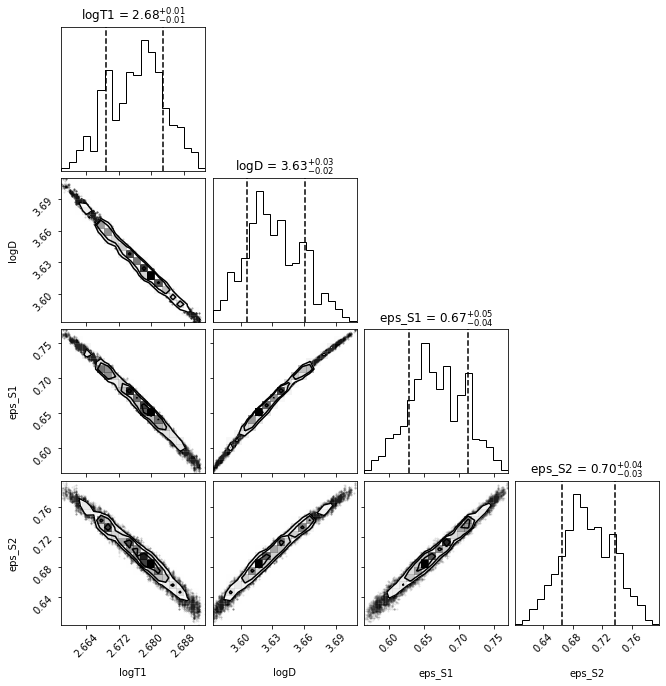

In [18]:
pick_run = "run3_withSigma"
pick_asteroid = 0 # 0 indexed

# Run NEATM
model = NEATM(verbose=False)
summary_neatm, model_observations_neatm, pymc_objs_neatm, figs = fit(
    model, 
    obs, 
    data[pick_asteroid:pick_asteroid+1],
    returnFigs=True,
    verbose=False,
    **fitDict[pick_run],
    **fitConfigDict
)

In [19]:
# Wavelength config for calculating SEDs
lambdaRange=[obs.filterQuadratureLambdas[0], obs.filterQuadratureLambdas[-1]]
lambdaNum=250

# For run 3
lambdaEdges=[obs.filterQuadratureLambdas[0], lambda_split, obs.filterQuadratureLambdas[-1]]
# Else
#lambdaEdges = None
linearInterpolation=False

SED_neatm_fit = calcFluxLambdaSED(
    model, 
    obs, 
    dataDict[pick_run][pick_asteroid:pick_asteroid+1],
    summary=summary_neatm,
    fitParameters=fitDict[pick_run]["fitParameters"],
    emissivitySpecification=fitDict[pick_run]["emissivitySpecification"],
    albedoSpecification=fitDict[pick_run]["albedoSpecification"],
    columnMapping=fitDict[pick_run]["columnMapping"],
    lambdaRange=lambdaRange,
    lambdaNum=lambdaNum,
    lambdaEdges=lambdaEdges,
    linearInterpolation=linearInterpolation,
  
)       

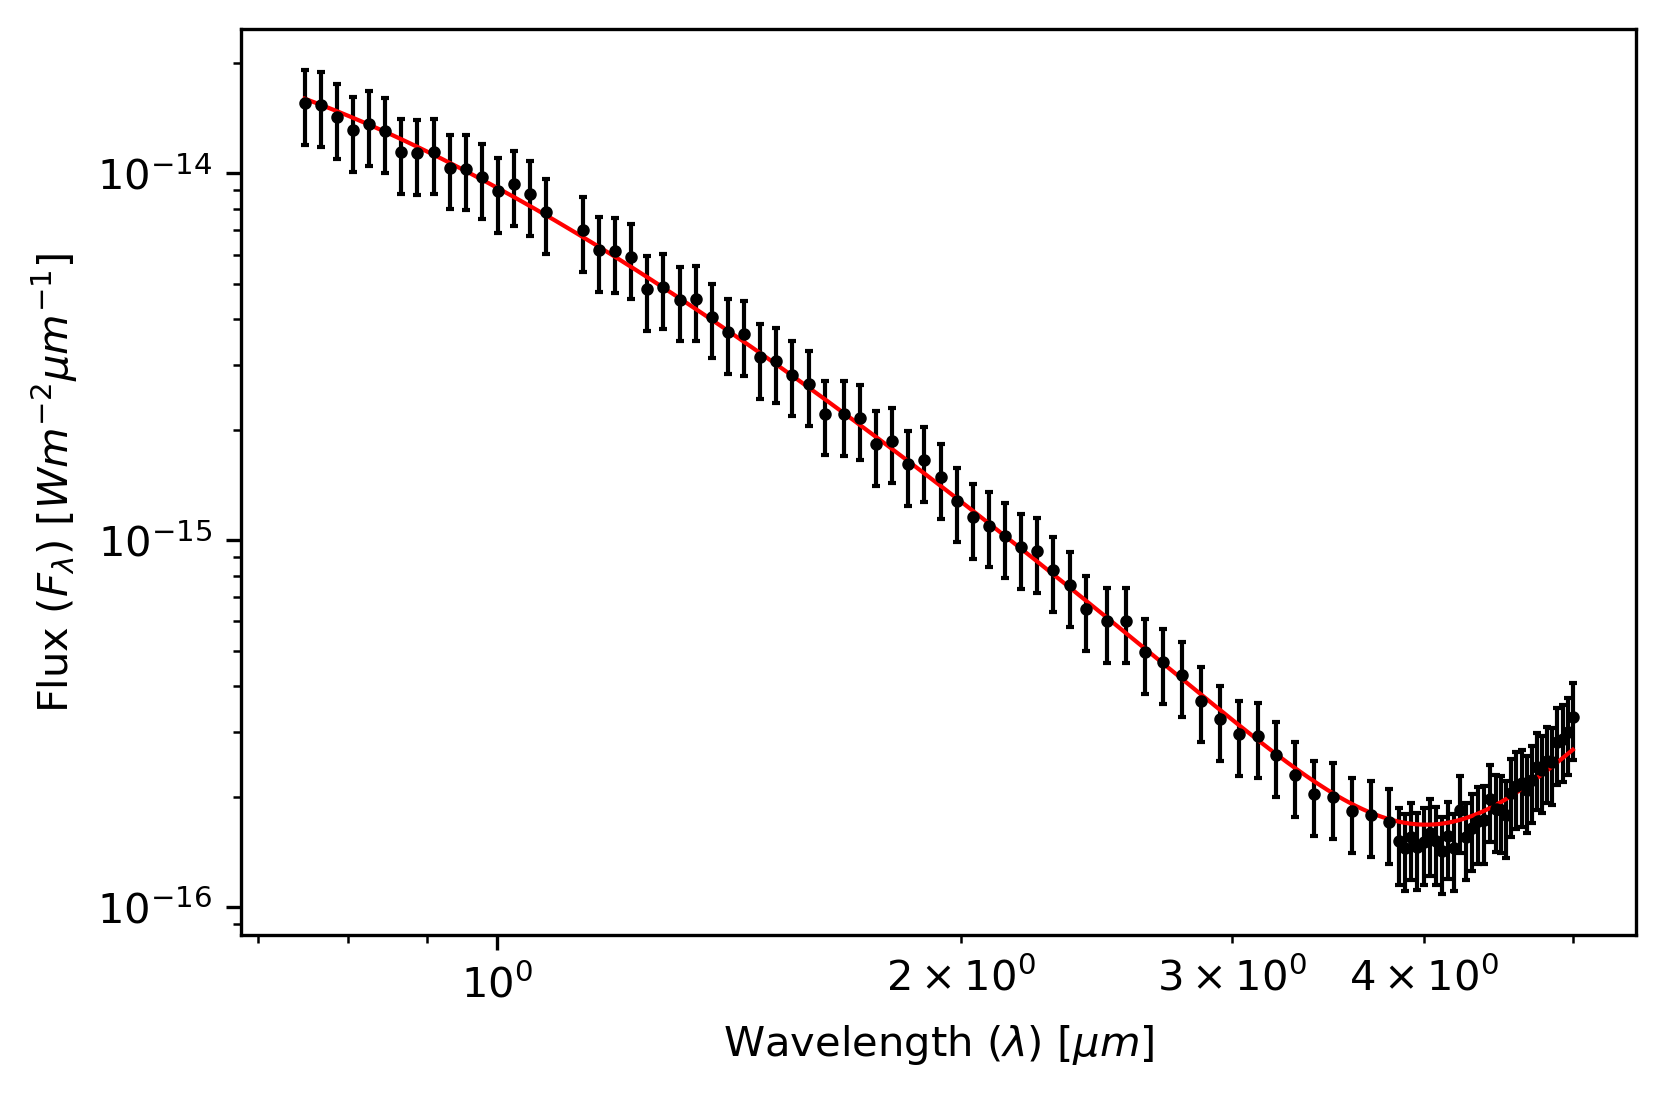

In [20]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotSED(
    SED_neatm_fit, 
    ax=ax, 
    plotKwargs={
        "label": "NEATM", 
        "c": "r", 
        "lw": 1
    }
)
plotObservations(
    obs, 
    dataDict[pick_run][pick_asteroid:pick_asteroid+1], 
    ax=ax, 
    columnMapping=columnMapping
)